# Evaluation of 2 Models

In [ ]:
model_1 = "pix2pix_1_0_input_base_2"
model_1_type = "pix2pix"  # hexa_wave_net, pix2pix, pix2pix_cfo
model_2 = "pix2pix_wgangp_1_0_input_base_2"
model_2_type = "pix2pix"  # hexa_wave_net, pix2pix, pix2pix_cfo
# for hexa wave net
model_variation_1 = 3
model_variation_2 = 3

data_1 = "../../data/nms1000_test_1_0_2500_2500_input_base"
data_1_type = "noise"
data_2 = "../../data/nms1000_test_1_0_2500_2500_input_base"
data_2_type = "noise"
physgen_variation = "sound_reflection"    # sound_baseline, sound_reflection, sound_diffraction, sound_combined

different_naming_1 = True
different_naming_2 = True

batch_size = 1
data_to_process_size = "inf"
image_size = 256

### Env Setup

In [40]:
# !conda create -n eval python=3.8 -y
# !conda activate eval

Activate now eval env and run:

In [41]:
# !pip install pandas
# !pip install ipython
# !pip install ipykernel
# !pip install opencv-python
# !pip install shapely
# !pip install pytorch-msssim
# !pip install scikit-image
# !pip install -r requirements.txt

> Set 'eval' as your python env

### Imports

In [42]:
import os
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2

In [43]:
!python --version

Python 3.8.20


### Helper

In [44]:
def imshow(img, title=None, image_width=10, axis=False,
           color_space="RGB", cmap=None, cols=1, save_to=None,
           hspace=0.2, wspace=0.2,
           use_original_sytle=False, invert=False, log=False):
    """
    Visualizes one or multiple images.

    Image will be reshaped: [batch_size/images, width, height, channels]

    ---
    Parameters:
    - img : np.ndarray
        Images/Images with [width, height, channels] or for multiple: [batch_size/images, width, height, channels].
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    - log : bool, optiona (default=False)
        Whether to log scale the plot or not
    """
    original_style = plt.rcParams.copy()

    img_shape = img.shape
    # print(f"Got images with shape: {img_shape}")

    # tranform the image to the right form
    if len(img_shape) == 2:
        img = np.reshape(img, (1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) == 3:
        # check if multiple gray images or multiple images with channel
        # if img.shape[2] < img.shape[0] and img.shape[1] == img.shape[2]:
        img = np.reshape(img, (1, img.shape[0], img.shape[1], img.shape[2]))
        # else:
        #     # there could be cases where this is wrong
        #     img = np.reshape(img, shape=(img.shape[0], img.shape[1], img.shape[2], 1))
    elif len(img_shape) != 4:
        raise ValueError(f"Image(s) have wrong shape! Founded shape: {img.shape}.")

    # print(f"Transformed shape to: {img_shape}")

    # get better look at reflections
    # mask = (img >= 200) & (img <= 240)
    # img[mask] -= 33
    # img = cv2.add(img, np.full(img.shape, 33, dtype=img.dtype))

    # Better distribution
    normalized_img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = normalized_img * (255)
    #img = cv2.equalizeHist(img)

    # invert images
    if invert:
        # print("Invert images...")
        max_value = 255 # 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    if log:
        img[img <= 0] = 1e-3
        # img = np.apply_along_axis(np.log, axis=0, arr=img)

    # Set visualization settings
    # aspect_ratio_width = img.shape[1] / img.shape[2]
    aspect_ratio = img.shape[2] / img.shape[1]

    n_images = img.shape[0]
    rows = n_images//cols + int(n_images % cols > 0)

    width = int(image_width * cols)
    height = int(image_width * rows * aspect_ratio)

    # set plt style
    if not use_original_sytle:
        plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
        plt.style.use(plt_style)
        # print(f"Using '{plt_style}' plotting style.")

    # plotting
    # print(f"Making you a beautiful plot...")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height))
    try:
        ax = ax.ravel()
    except AttributeError:
        ax = [ax]
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    if type(title) == str:
        fig.suptitle(title, fontsize=128, y=0.95)

    for idx in range(len(ax)):
        cur_ax = ax[idx]

        if idx >= len(img):
            cur_ax.axis("off")
            continue

        cur_img = img[idx]

        if color_space.lower() == "bgr":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
            used_cmap = None
        elif color_space.lower() == "rgb":
            cur_img = cur_img
            used_cmap = None
        elif color_space.lower() == "hsv":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_HSV2RGB)
            used_cmap = None
        elif color_space.lower() in ["gray", "grey", "g"]:
            if len(cur_img.shape) == 3 and cur_img.shape[2] == 3:
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)
            else:
                cur_img = cur_img
            # print(cur_img.shape)
            used_cmap = "gray"

        if cmap:
            used_cmap = cmap

        if type(title) in [list, tuple]:
            cur_ax.set_title(title[idx], fontsize=64)
        if axis == False:
            cur_ax.axis("off")

        if log:
            cur_ax.imshow(cur_img, cmap=used_cmap, norm=LogNorm())
        else:
            cur_ax.imshow(cur_img, cmap=used_cmap)

    if save_to:
        os.makedirs(os.path.split(save_to)[0], exist_ok=True)
        fig.savefig(save_to, dpi=300)

    plt.show()

    if not use_original_sytle:
        # reset to original plt style
        plt.rcParams.update(original_style)

def show_images(image_paths:list, title=None, image_width=5, axis=False,
                color_space="gray", cmap=None, 
                cols=2, save_to=None,
                hspace=0.01, wspace=0.01,
                use_original_sytle=False, invert=False, log=False):
    """
    Visulalizes/shows one or multiple images.

    ---
    Parameters:
    - image_paths : List[str]
        List of paths to the images which should get visualized.
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    - log : bool, optiona (default=False)
        Whether to log scale the plot or not
    """
    if color_space.lower() == "rgb":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in image_paths])
    elif color_space.lower() == "hsv":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2HSV) for img in image_paths])
    elif color_space.lower() in ["grey", "gray", "g"]:
        images = np.array([cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in image_paths])
        images = np.reshape(images, (images.shape[0], images.shape[1], images.shape[2], 1))
    else:
        images = np.array([cv2.imread(img) for img in image_paths])
    imshow(images, title=title, image_width=image_width, axis=axis,
           color_space=color_space, cmap=cmap, cols=cols, save_to=save_to,
           hspace=hspace, wspace=wspace,
           use_original_sytle=use_original_sytle, invert=invert, log=log)
    return images

### Run Tests

In [ ]:
command = (
  f"python test.py "
  f"--dataroot {data_1} "
  f"--name {model_1} "
  f"--model {model_1_type} "
  f"--batch_size {batch_size} "
  f"--dataset_mode {data_1_type} "
  f"--input_nc 1 "
  f"--output_nc 1 "
  f"--load_size {image_size} "
  f"--netG unet_256 "
  f"--max_dataset_size {data_to_process_size} "
  f"--num_test {data_to_process_size} "
  f"--results_dir ./eval/{model_1} "
  f"--phase test "
  f"--eval"
)

if model_type_1 == "hexa_wave_net":
  command += f" --model_type {model_variation_1}"

if different_naming_1:
  command += " --different_building_naming"

if data_1_type == "physgen":
  command += f" --variation {physgen_variation}"

# Finally run it
!{command}

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../../data/nms1000_test_1_0_2500_2500_input_base	[default: None]
             dataset_mode: noise                         	[default: aligned]
different_building_naming: True                          	[default: False]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[

In [ ]:
command = (
  f"python test.py "
  f"--dataroot {data_2} "
  f"--name {model_2} "
  f"--model {model_2_type} "
  f"--batch_size {batch_size} "
  f"--dataset_mode {data_2_type} "
  f"--input_nc 1 "
  f"--output_nc 1 "
  f"--load_size {image_size} "
  f"--netG unet_256 "
  f"--max_dataset_size {data_to_process_size} "
  f"--num_test {data_to_process_size} "
  f"--results_dir ./eval/{model_2} "
  f"--phase test "
  f"--eval"
)

if model_type_2 == "hexa_wave_net":
  command += f" --model_type {model_variation_2}"

if different_naming_2:
  command += " --different_building_naming"

if data_2_type == "physgen":
  command += f" --variation {physgen_variation}"

# Run it
!{command}

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../../data/nms1000_test_1_0_2500_2500_input_base	[default: None]
             dataset_mode: noise                         	[default: aligned]
different_building_naming: True                          	[default: False]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[

### Extract Test Predictions

In [47]:
evaluation_path = f"./eval/{model_1}/{model_1}/test_latest/images"
target_path = f"../../data/eval/{model_1}"

In [48]:
!python eval_extractor.py \
    --name {model_1} \
    --evaluation_path {evaluation_path} \
    --target_path {target_path}

[info] copied pred from './eval/pix2pix_1_0_input_base_2/pix2pix_1_0_input_base_2/test_latest/images/888_LAEQ_256_fake_B.png' to '../../data/eval/pix2pix_1_0_input_base_2/pred/888_LAEQ.png'
[info] copied osm from './eval/pix2pix_1_0_input_base_2/pix2pix_1_0_input_base_2/test_latest/images/348_LAEQ_256_real_A.png' to '../../data/eval/pix2pix_1_0_input_base_2/osm/348_LAEQ.png'
[info] copied osm from './eval/pix2pix_1_0_input_base_2/pix2pix_1_0_input_base_2/test_latest/images/519_LAEQ_256_real_A.png' to '../../data/eval/pix2pix_1_0_input_base_2/osm/519_LAEQ.png'
[info] copied real from './eval/pix2pix_1_0_input_base_2/pix2pix_1_0_input_base_2/test_latest/images/634_LAEQ_256_real_B.png' to '../../data/eval/pix2pix_1_0_input_base_2/real/634_LAEQ.png'
[info] copied pred from './eval/pix2pix_1_0_input_base_2/pix2pix_1_0_input_base_2/test_latest/images/855_LAEQ_256_fake_B.png' to '../../data/eval/pix2pix_1_0_input_base_2/pred/855_LAEQ.png'
[info] copied pred from './eval/pix2pix_1_0_input_base

In [49]:
evaluation_path = f"./eval/{model_2}/{model_2}/test_latest/images"
target_path = f"../../data/eval/{model_2}"

In [50]:
!python eval_extractor.py \
    --name {model_2} \
    --evaluation_path {evaluation_path} \
    --target_path {target_path}

[info] copied pred from './eval/pix2pix_wgangp_1_0_input_base_2/pix2pix_wgangp_1_0_input_base_2/test_latest/images/888_LAEQ_256_fake_B.png' to '../../data/eval/pix2pix_wgangp_1_0_input_base_2/pred/888_LAEQ.png'
[info] copied osm from './eval/pix2pix_wgangp_1_0_input_base_2/pix2pix_wgangp_1_0_input_base_2/test_latest/images/348_LAEQ_256_real_A.png' to '../../data/eval/pix2pix_wgangp_1_0_input_base_2/osm/348_LAEQ.png'
[info] copied osm from './eval/pix2pix_wgangp_1_0_input_base_2/pix2pix_wgangp_1_0_input_base_2/test_latest/images/519_LAEQ_256_real_A.png' to '../../data/eval/pix2pix_wgangp_1_0_input_base_2/osm/519_LAEQ.png'
[info] copied real from './eval/pix2pix_wgangp_1_0_input_base_2/pix2pix_wgangp_1_0_input_base_2/test_latest/images/634_LAEQ_256_real_B.png' to '../../data/eval/pix2pix_wgangp_1_0_input_base_2/real/634_LAEQ.png'
[info] copied pred from './eval/pix2pix_wgangp_1_0_input_base_2/pix2pix_wgangp_1_0_input_base_2/test_latest/images/855_LAEQ_256_fake_B.png' to '../../data/eval/

### Calc Eval metrics

In [51]:
!python eval_metrics.py \
    --data_dir ../../data/eval/{model_1}/real \
    --pred_dir ../../data/eval/{model_1}/pred \
    --osm_dir ../../data/eval/{model_1}/osm \
    --output ./eval_results/evaluation_{model_1}.csv

Evaluating samples:   0%|                              | 0/1000 [00:00<?, ?it/s]

Evaluating samples: 100%|███████████████████| 1000/1000 [00:21<00:00, 46.94it/s]
               MAE         MAPE  ...    LoS_wMAPE   NLoS_wMAPE
count  1000.000000  1000.000000  ...  1000.000000  1000.000000
mean      0.657123     3.693280  ...     3.693258     5.193099
std       1.167599     4.976259  ...     4.976089    19.222919
min       0.092271     0.456914  ...     0.456921     0.000000
25%       0.237403     1.604261  ...     1.604272     0.869560
50%       0.328614     2.316495  ...     2.316516     0.900905
75%       0.551455     3.678880  ...     3.678936     1.785713
max      11.151529    55.063774  ...    55.063091   100.000000

[8 rows x 6 columns]


In [52]:
!python eval_metrics.py \
    --data_dir ../../data/eval/{model_2}/real \
    --pred_dir ../../data/eval/{model_2}/pred \
    --osm_dir ../../data/eval/{model_2}/osm \
    --output ./eval_results/evaluation_{model_2}.csv

Evaluating samples:   1%|▏                     | 6/1000 [00:00<00:55, 17.87it/s]

Evaluating samples: 100%|███████████████████| 1000/1000 [00:21<00:00, 46.86it/s]
               MAE         MAPE  ...    LoS_wMAPE   NLoS_wMAPE
count  1000.000000  1000.000000  ...  1000.000000  1000.000000
mean      0.354687     2.281960  ...     2.281991     0.221651
std       0.285496     1.743449  ...     1.743476     0.382935
min       0.034551     0.169442  ...     0.169432     0.000000
25%       0.152203     1.009849  ...     1.009854     0.000000
50%       0.256952     1.688700  ...     1.688725     0.000000
75%       0.500385     3.165797  ...     3.165846     0.806447
max       2.228890    12.574408  ...    12.574599     1.612902

[8 rows x 6 columns]


### Show Results

In [53]:
mae_model_1_name = f'MAE_{model_1}'
los_mae_model_1_name = f'LoS_MAE_{model_1}'
nlos_mae_model_1_name = f'NLoS_MAE_{model_1}'
mape_model_1_name = f'MAPE_{model_1}'
los_wmape_model_1_name = f'LoS_wMAPE_{model_1}'
nlos_wmape_model_1_name = f'NLoS_wMAPE_{model_1}'

mae_model_2_name = f'MAE_{model_2}'
los_mae_model_2_name = f'LoS_MAE_{model_2}'
nlos_mae_model_2_name = f'NLoS_MAE_{model_2}'
mape_model_2_name = f'MAPE_{model_2}'
los_wmape_model_2_name = f'LoS_wMAPE_{model_2}'
nlos_wmape_model_2_name = f'NLoS_wMAPE_{model_2}'

In [54]:
df_1 = pd.read_csv(f"./eval_results/evaluation_{model_1}.csv")
# df_1 = df_1.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_1 = df_1.rename(columns={'MAE': mae_model_1_name, 
                            'LoS_MAE': los_mae_model_1_name,
                            'NLoS_MAE': nlos_mae_model_1_name,
                            'MAPE':mape_model_1_name,
                            'LoS_wMAPE': los_wmape_model_1_name,
                            'NLoS_wMAPE': nlos_wmape_model_1_name
                            }
                   )
# extract sample_ids
sample_id_series = df_1["sample_id"].str.extract(r'^(\d+)_')[0]
if sample_id_series.isna().sum() > 1:
    sample_id_series = df_1["sample_id"].str.extract(r'(\d+)')[0]
if sample_id_series.isna().sum() > 1:
    raise ValueError(f"Found {sample_id_series.isna().sum()} Nans")
df_1["sample_id"] = sample_id_series
print("Nan found in sample ids:", df_1["sample_id"].isna().sum())
df_1 = df_1.dropna(subset=["sample_id"])
df_1["sample_id"] = df_1["sample_id"].astype(int)
df_1

Nan found in sample ids: 0


,sample_id,MAE_pix2pix_1_0_input_base_2,MAPE_pix2pix_1_0_input_base_2,LoS_MAE_pix2pix_1_0_input_base_2,NLoS_MAE_pix2pix_1_0_input_base_2,LoS_wMAPE_pix2pix_1_0_input_base_2,NLoS_wMAPE_pix2pix_1_0_input_base_2
0,707,0.419814,3.141932,0.419815,0.392155,3.141966,0.943391
1,283,0.532891,3.398218,0.532893,0.392159,3.398257,0.854704
2,584,0.866466,5.956826,0.866467,0.784313,5.956887,1.960783
3,967,0.579648,3.171939,0.579657,0.000000,3.171987,0.000000
4,132,0.707098,4.975394,0.707103,0.392159,4.975456,0.925930
...,...,...,...,...,...,...,...
995,92,0.302178,1.918989,0.302171,0.784313,1.918990,1.851851
996,435,6.277735,29.715887,6.277221,39.999996,29.714819,100.000000
997,197,0.721825,4.547777,0.721830,0.392155,4.547833,0.925921
998,689,0.231766,1.470982,0.231764,0.392155,1.470991,0.854696


In [55]:
df_2 = pd.read_csv(f"./eval_results/evaluation_{model_2}.csv")
# df_2 = df_2.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_2 = df_2.rename(columns={'MAE': mae_model_2_name, 
                            'LoS_MAE': los_mae_model_2_name,
                            'NLoS_MAE': nlos_mae_model_2_name,
                            'MAPE':mape_model_2_name,
                            'LoS_wMAPE': los_wmape_model_2_name,
                            'NLoS_wMAPE': nlos_wmape_model_2_name
                            }
                   )
# extract sample_ids
sample_id_series = df_2["sample_id"].str.extract(r'^(\d+)_')[0]
if sample_id_series.isna().sum() > 1:
    sample_id_series = df_2["sample_id"].str.extract(r'(\d+)')[0]
if sample_id_series.isna().sum() > 1:
    raise ValueError(f"Found {sample_id_series.isna().sum()} Nans")
df_2["sample_id"] = sample_id_series
print("Nan found in sample ids:", df_2["sample_id"].isna().sum())
df_2 = df_2.dropna(subset=["sample_id"])
df_2["sample_id"] = df_2["sample_id"].astype(int)
df_2

Nan found in sample ids: 0


,sample_id,MAE_pix2pix_wgangp_1_0_input_base_2,MAPE_pix2pix_wgangp_1_0_input_base_2,LoS_MAE_pix2pix_wgangp_1_0_input_base_2,NLoS_MAE_pix2pix_wgangp_1_0_input_base_2,LoS_wMAPE_pix2pix_wgangp_1_0_input_base_2,NLoS_wMAPE_pix2pix_wgangp_1_0_input_base_2
0,707,0.361149,2.296219,0.361154,0.000000,2.296254,0.000000
1,283,0.468888,2.692824,0.468895,0.000000,2.692865,0.000000
2,584,0.821731,5.469676,0.821743,0.000000,5.469760,0.000000
3,967,1.118278,8.529572,1.118289,0.392159,8.529690,0.840340
4,132,0.663943,5.176114,0.663953,0.000000,5.176193,0.000000
...,...,...,...,...,...,...,...
995,92,0.198053,1.184264,0.198056,0.000000,1.184282,0.000000
996,435,0.610292,4.165001,0.610295,0.392159,4.165049,0.980396
997,197,0.565299,3.495448,0.565308,0.000000,3.495501,0.000000
998,689,0.103652,0.725998,0.103648,0.392155,0.725996,0.854696


In [56]:
merged_df = pd.merge(df_1, df_2, on='sample_id', how='outer')
print(f"Value Counts:\n{merged_df.value_counts()}")
print(f"\n\nNulls:\n{merged_df.isna().sum()}\n\n")
merged_df

Value Counts:
sample_id  MAE_pix2pix_1_0_input_base_2  MAPE_pix2pix_1_0_input_base_2  LoS_MAE_pix2pix_1_0_input_base_2  NLoS_MAE_pix2pix_1_0_input_base_2  LoS_wMAPE_pix2pix_1_0_input_base_2  NLoS_wMAPE_pix2pix_1_0_input_base_2  MAE_pix2pix_wgangp_1_0_input_base_2  MAPE_pix2pix_wgangp_1_0_input_base_2  LoS_MAE_pix2pix_wgangp_1_0_input_base_2  NLoS_MAE_pix2pix_wgangp_1_0_input_base_2  LoS_wMAPE_pix2pix_wgangp_1_0_input_base_2  NLoS_wMAPE_pix2pix_wgangp_1_0_input_base_2
0          0.539712                      3.116012                       0.539708                          0.784313                           3.116029                            1.960783                             0.556305                             3.121728                              0.556314                                 0.000000                                  3.121776                                   0.000000                                      1
671        0.207125                      1.035484                

,sample_id,MAE_pix2pix_1_0_input_base_2,MAPE_pix2pix_1_0_input_base_2,LoS_MAE_pix2pix_1_0_input_base_2,NLoS_MAE_pix2pix_1_0_input_base_2,LoS_wMAPE_pix2pix_1_0_input_base_2,NLoS_wMAPE_pix2pix_1_0_input_base_2,MAE_pix2pix_wgangp_1_0_input_base_2,MAPE_pix2pix_wgangp_1_0_input_base_2,LoS_MAE_pix2pix_wgangp_1_0_input_base_2,NLoS_MAE_pix2pix_wgangp_1_0_input_base_2,LoS_wMAPE_pix2pix_wgangp_1_0_input_base_2,NLoS_wMAPE_pix2pix_wgangp_1_0_input_base_2
0,707,0.419814,3.141932,0.419815,0.392155,3.141966,0.943391,0.361149,2.296219,0.361154,0.000000,2.296254,0.000000
1,283,0.532891,3.398218,0.532893,0.392159,3.398257,0.854704,0.468888,2.692824,0.468895,0.000000,2.692865,0.000000
2,584,0.866466,5.956826,0.866467,0.784313,5.956887,1.960783,0.821731,5.469676,0.821743,0.000000,5.469760,0.000000
3,967,0.579648,3.171939,0.579657,0.000000,3.171987,0.000000,1.118278,8.529572,1.118289,0.392159,8.529690,0.840340
4,132,0.707098,4.975394,0.707103,0.392159,4.975456,0.925930,0.663943,5.176114,0.663953,0.000000,5.176193,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,92,0.302178,1.918989,0.302171,0.784313,1.918990,1.851851,0.198053,1.184264,0.198056,0.000000,1.184282,0.000000
996,435,6.277735,29.715887,6.277221,39.999996,29.714819,100.000000,0.610292,4.165001,0.610295,0.392159,4.165049,0.980396
997,197,0.721825,4.547777,0.721830,0.392155,4.547833,0.925921,0.565299,3.495448,0.565308,0.000000,3.495501,0.000000
998,689,0.231766,1.470982,0.231764,0.392155,1.470991,0.854696,0.103652,0.725998,0.103648,0.392155,0.725996,0.854696


Using 'seaborn-v0_8' plotting style.

MAE
    - pix2pix_1_0_input_base_2: 0.66
    - pix2pix_wgangp_1_0_input_base_2: 0.35

MAPE
    - pix2pix_1_0_input_base_2: 3.69
    - pix2pix_wgangp_1_0_input_base_2: 2.28

LoS MAE
    - pix2pix_1_0_input_base_2: 0.66
    - pix2pix_wgangp_1_0_input_base_2: 0.35

NLoS MAE
    - pix2pix_1_0_input_base_2: 2.27
    - pix2pix_wgangp_1_0_input_base_2: 0.10

LoS wMAPE
    - pix2pix_1_0_input_base_2: 3.69
    - pix2pix_wgangp_1_0_input_base_2: 2.28

NLoS wMAPE
    - pix2pix_1_0_input_base_2: 5.19
    - pix2pix_wgangp_1_0_input_base_2: 0.22


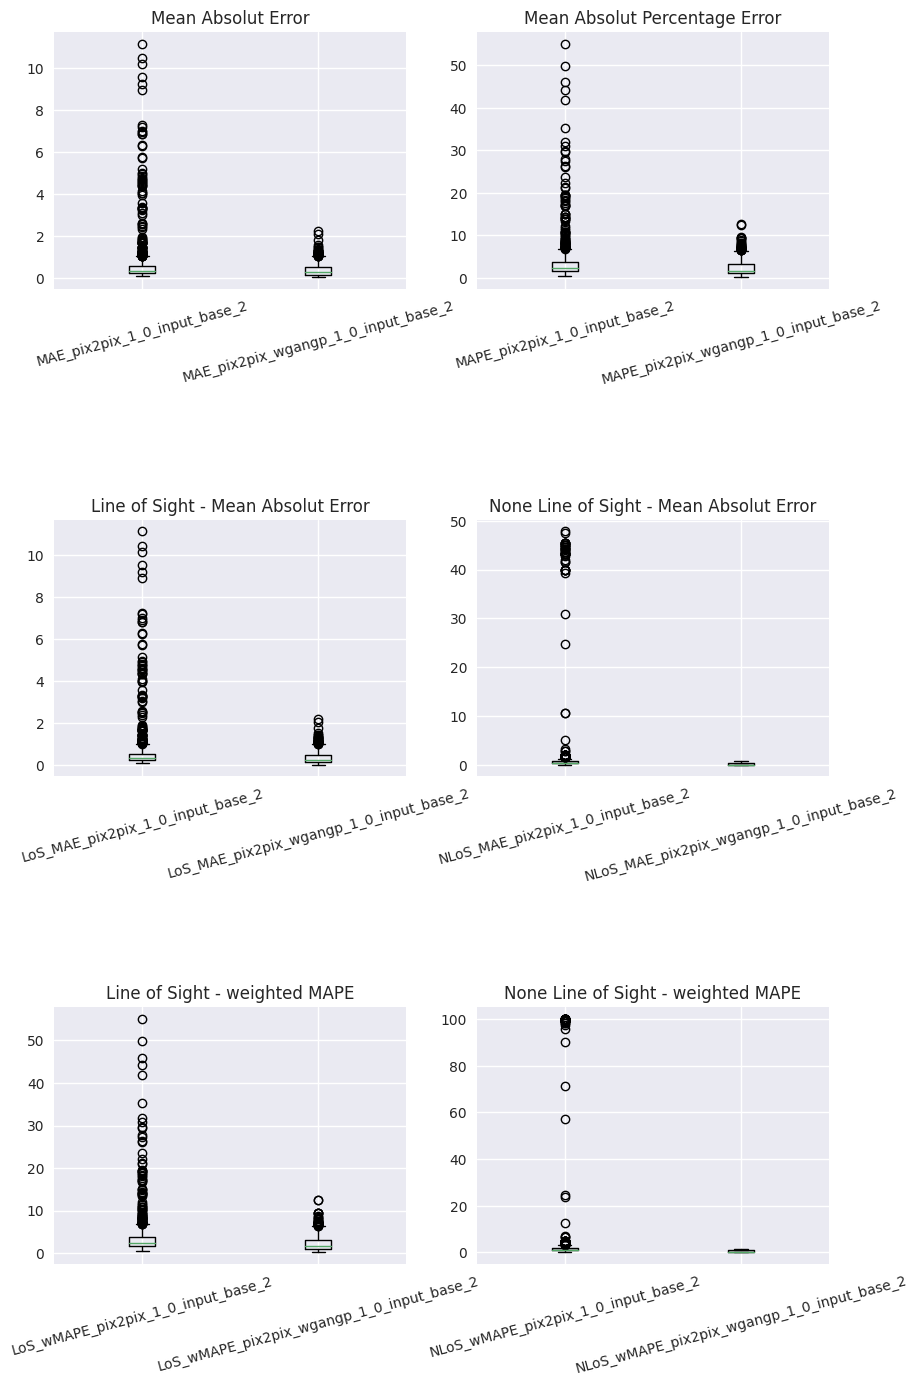

In [57]:
plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
plt.style.use(plt_style)
print(f"Using '{plt_style}' plotting style.")

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10, 16))
# ax = ax.flatten()

# MEA
values = [merged_df[mae_model_1_name], merged_df[mae_model_2_name]]
names = [mae_model_1_name, mae_model_2_name]
ax[0][0].boxplot(x=values, notch=False)
ax[0][0].set_xticks([1, 2], names)
ax[0][0].set_xticklabels(names, rotation=15)
ax[0][0].set_title("Mean Absolut Error")

# MAPE
values = [merged_df[mape_model_1_name], merged_df[mape_model_2_name]]
names = [mape_model_1_name, mape_model_2_name]
ax[0][1].boxplot(x=values, notch=False)
ax[0][1].set_xticks([1, 2], names)
ax[0][1].set_xticklabels(names, rotation=15)
ax[0][1].set_title("Mean Absolut Percentage Error")

# LoS MEA
values = [merged_df[los_mae_model_1_name], merged_df[los_mae_model_2_name]]
names = [los_mae_model_1_name, los_mae_model_2_name]
ax[1][0].boxplot(x=values, notch=False)
ax[1][0].set_xticks([1, 2], names)
ax[1][0].set_xticklabels(names, rotation=15)
ax[1][0].set_title("Line of Sight - Mean Absolut Error")

# NLoS MEA
values = [merged_df[nlos_mae_model_1_name], merged_df[nlos_mae_model_2_name]]
names = [nlos_mae_model_1_name, nlos_mae_model_2_name]
ax[1][1].boxplot(x=values, notch=False)
ax[1][1].set_xticks([1, 2], names)
ax[1][1].set_xticklabels(names, rotation=15)
ax[1][1].set_title("None Line of Sight - Mean Absolut Error")

# LoS wMAPE
values = [merged_df[los_wmape_model_1_name], merged_df[los_wmape_model_2_name]]
names = [los_wmape_model_1_name, los_wmape_model_2_name]
ax[2][0].boxplot(x=values, notch=False)
ax[2][0].set_xticks([1, 2], names)
ax[2][0].set_xticklabels(names, rotation=15)
ax[2][0].set_title("Line of Sight - weighted MAPE")

# NLoS wMAPE
values = [merged_df[nlos_wmape_model_1_name], merged_df[nlos_wmape_model_2_name]]
names = [nlos_wmape_model_1_name, nlos_wmape_model_2_name]
ax[2][1].boxplot(x=values, notch=False)
ax[2][1].set_xticks([1, 2], names)
ax[2][1].set_xticklabels(names, rotation=15)
ax[2][1].set_title("None Line of Sight - weighted MAPE")

plt.subplots_adjust(hspace=0.9)

print(f"\nMAE\n    - {model_1}: {merged_df[mae_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[mae_model_2_name].mean():>0.2f}")
print(f"\nMAPE\n    - {model_1}: {merged_df[mape_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[mape_model_2_name].mean():>0.2f}")
print(f"\nLoS MAE\n    - {model_1}: {merged_df[los_mae_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[los_mae_model_2_name].mean():>0.2f}")
print(f"\nNLoS MAE\n    - {model_1}: {merged_df[nlos_mae_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[nlos_mae_model_2_name].mean():>0.2f}")
print(f"\nLoS wMAPE\n    - {model_1}: {merged_df[los_wmape_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[los_wmape_model_2_name].mean():>0.2f}")
print(f"\nNLoS wMAPE\n    - {model_1}: {merged_df[nlos_wmape_model_1_name].mean():>0.2f}\n    - {model_2}: {merged_df[nlos_wmape_model_2_name].mean():>0.2f}")

Example Image

In [58]:
def get_same_pred_real_samples(pred_path:str, real_path:str, input_path:str, n_samples:int, ids=None):
    if not ids:
        # choose n random samples
        samples = random.sample(os.listdir(pred_path), n_samples)
        pred_samples = [os.path.join(pred_path, cur_image) for cur_image in samples]

        # get the used id's
        ids = []
        for cur_image in samples:
            cur_id = re.findall(r'\d+', string=cur_image)
            if len(cur_id) <= 0:
                raise ValueError(f"One image has no ID: {cur_image}")
            cur_id = cur_id[-1]
            ids += [cur_id]
    else:
        # get pred image
        pred_image_samples = []
        for target_id in ids:
            found = False
            for cur_image in os.listdir(real_path):
                cur_id = re.findall('\d+', string=cur_image)
                cur_id = cur_id[-1]
                if cur_id == target_id:
                    pred_image_samples += [cur_image]
                    found = True
                    break

            if not found:
                raise ValueError(f"Does not found pred image with id: {target_id}")
        pred_samples = [os.path.join(pred_path, cur_image) for cur_image in pred_image_samples]

    # get real image
    real_image_samples = []
    for target_id in ids:
        found = False
        for cur_image in os.listdir(real_path):
            cur_id = re.findall('\d+', string=cur_image)
            cur_id = cur_id[-1]
            if cur_id == target_id:
                real_image_samples += [cur_image]
                found = True
                break

        if not found:
            raise ValueError(f"Does not found real image with id: {target_id}")

    target_samples = [os.path.join(real_path, cur_image) for cur_image in real_image_samples]

    # get real image
    input_image_samples = []
    if input_path:
        for target_id in ids:
            found = False
            for cur_image in os.listdir(input_path):
                cur_id = re.findall('\d+', string=cur_image)
                cur_id = cur_id[-1]
                if cur_id == target_id:
                    input_image_samples += [cur_image]
                    found = True
                    break

            if not found:
                raise ValueError(f"Does not found input image with id: {target_id}")

    input_samples = [os.path.join(input_path, cur_image) for cur_image in input_image_samples]

    return input_samples, target_samples, pred_samples, ids

In [59]:
# from matplotlib.colors import ListedColormap

# def get_unique_hsv_cmap():
#     unique_hsv_map = plt.get_cmap("hsv")(np.linspace(0, 1, 256))    # np.arange(0, 256)
#     hsv_map = plt.get_cmap("hsv")
#     for cur_idx in range(256):
#         r, g, b, a = hsv_map(cur_idx)
#         if r > 0.99 and g < (170/255):
#             gray_value = cur_idx*8 / 255.0
#             unique_hsv_map[cur_idx] = (gray_value, gray_value, gray_value, 1.0)
#         else:
#             break
#     unique_hsv = ListedColormap(unique_hsv_map)
#     plt.colormaps.register(name="unique_hsv", cmap=unique_hsv, force=True)
#     return unique_hsv

# # for i in range(256):
# #     print([int(cur_color*255) for cur_color in get_cmap('hsv')(i)])

# get_unique_hsv_cmap()
# plt.get_cmap("unique_hsv")

In [88]:
def plot(ax, path, title="", sub_image=None, cmap="plasma", plot=True, vmin=None, vmax=None):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = 255 - img

    if sub_image:
        img_2 = cv2.imread(sub_image, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img_2 = 255 - img_2

        assert img_2.shape == img.shape, "Shape mismatch"
        img = np.abs(img - img_2)
        # img = img - img_2
        # img[img < 0] = img[img < 0] * -1

    if plot:
        ax.axis("off")
        color_ax = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        plt.colorbar(color_ax, ax=ax, fraction=0.046, pad=0.04)
    
    return img

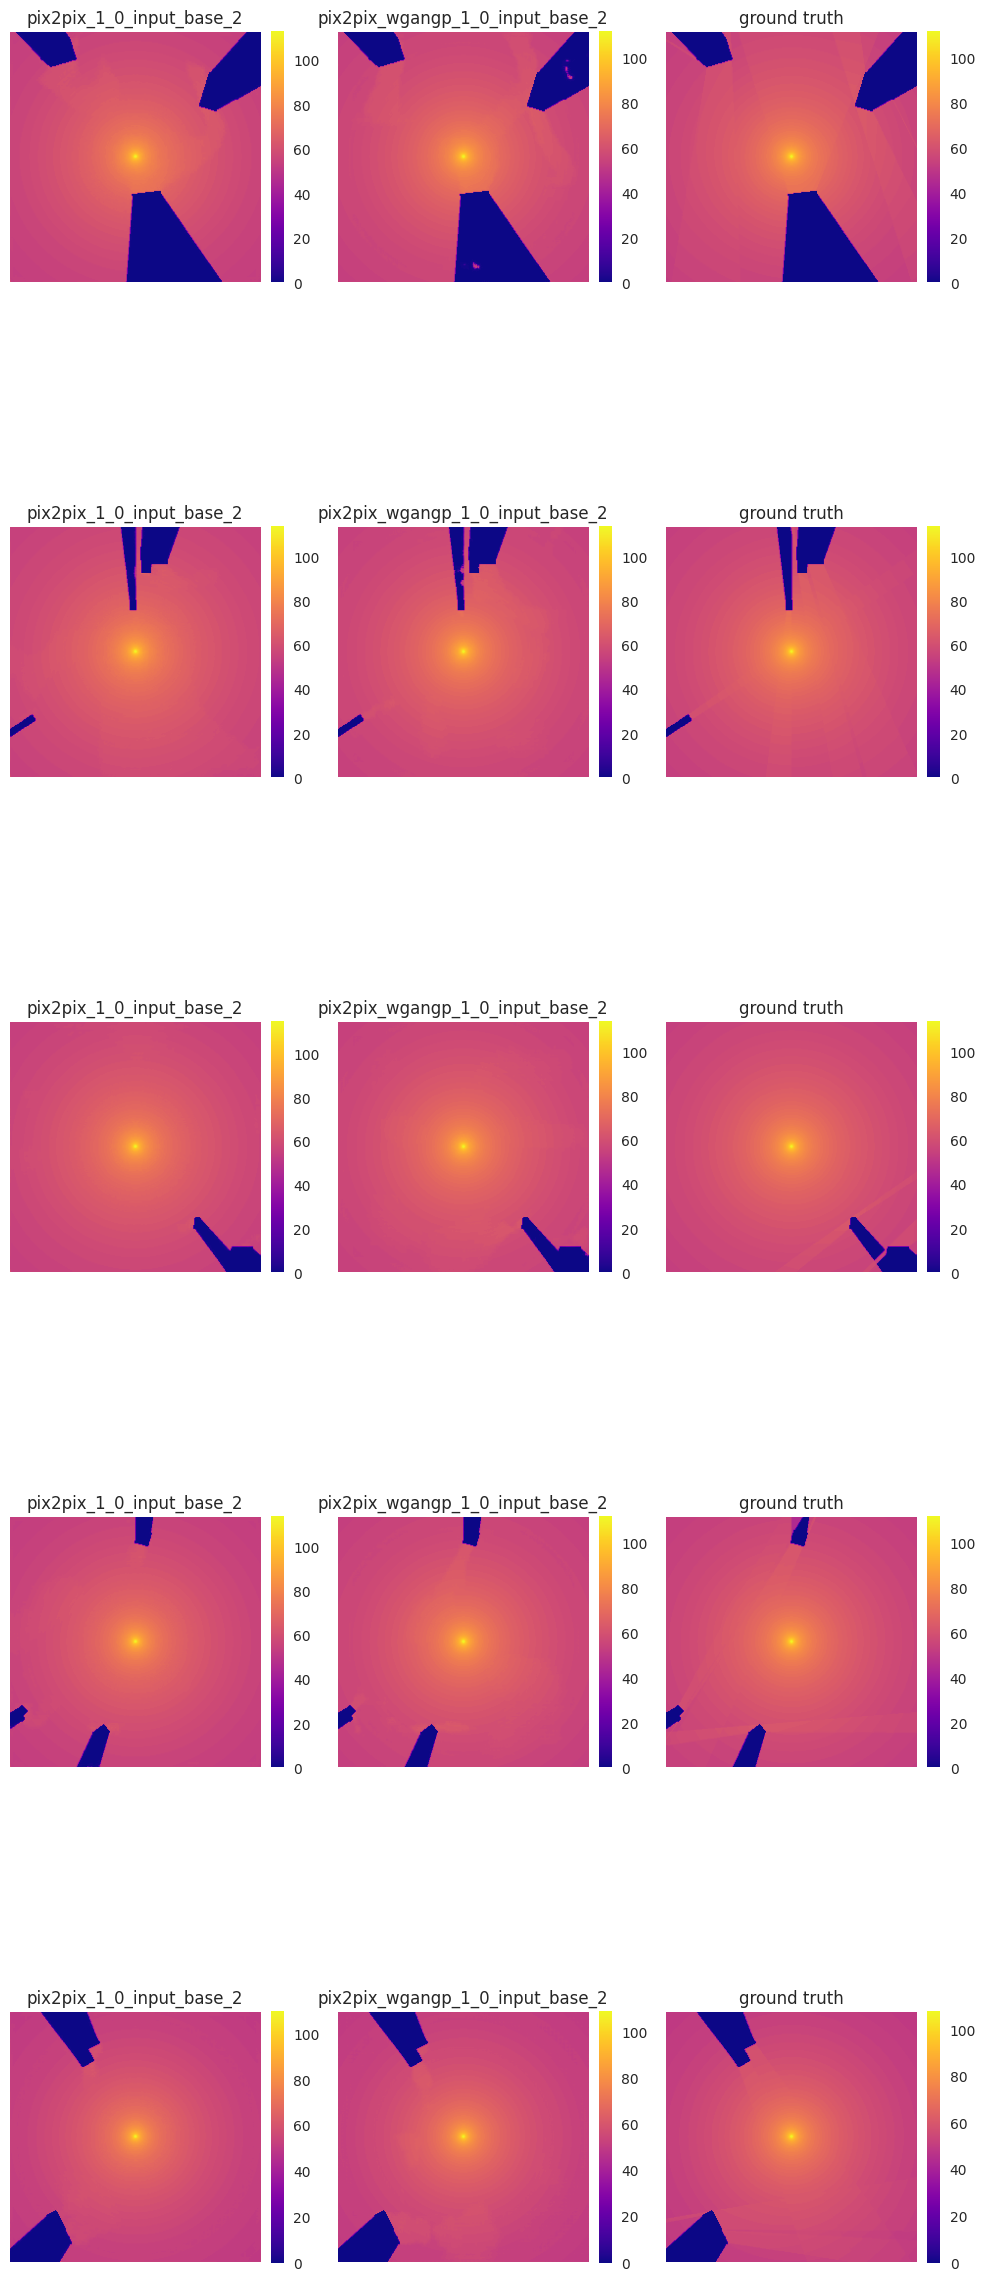

In [89]:
n_samples = 5

input_samples, real, pred_model_1, ids = get_same_pred_real_samples(f"../../data/eval/{model_1}/pred",
                                                                    f"../../data/eval/{model_1}/real",
                                                                    None,
                                                                    n_samples)
_, _, pred_model_2, ids = get_same_pred_real_samples(f"../../data/eval/{model_2}/pred",
                                                     f"../../data/eval/{model_2}/real",
                                                     None,
                                                     n_samples, ids)

fig, ax = plt.subplots(nrows=n_samples, ncols=3, figsize=(3*4, n_samples*6))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(pred_model_1):
    plot(ax[idx][0], path=cur_path, title=f"{model_1}")

for idx, cur_path in enumerate(pred_model_2):
    plot(ax[idx][1], path=cur_path, title=f"{model_2}")

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"ground truth")

plt.subplots_adjust(hspace=0.5)

plt.show();

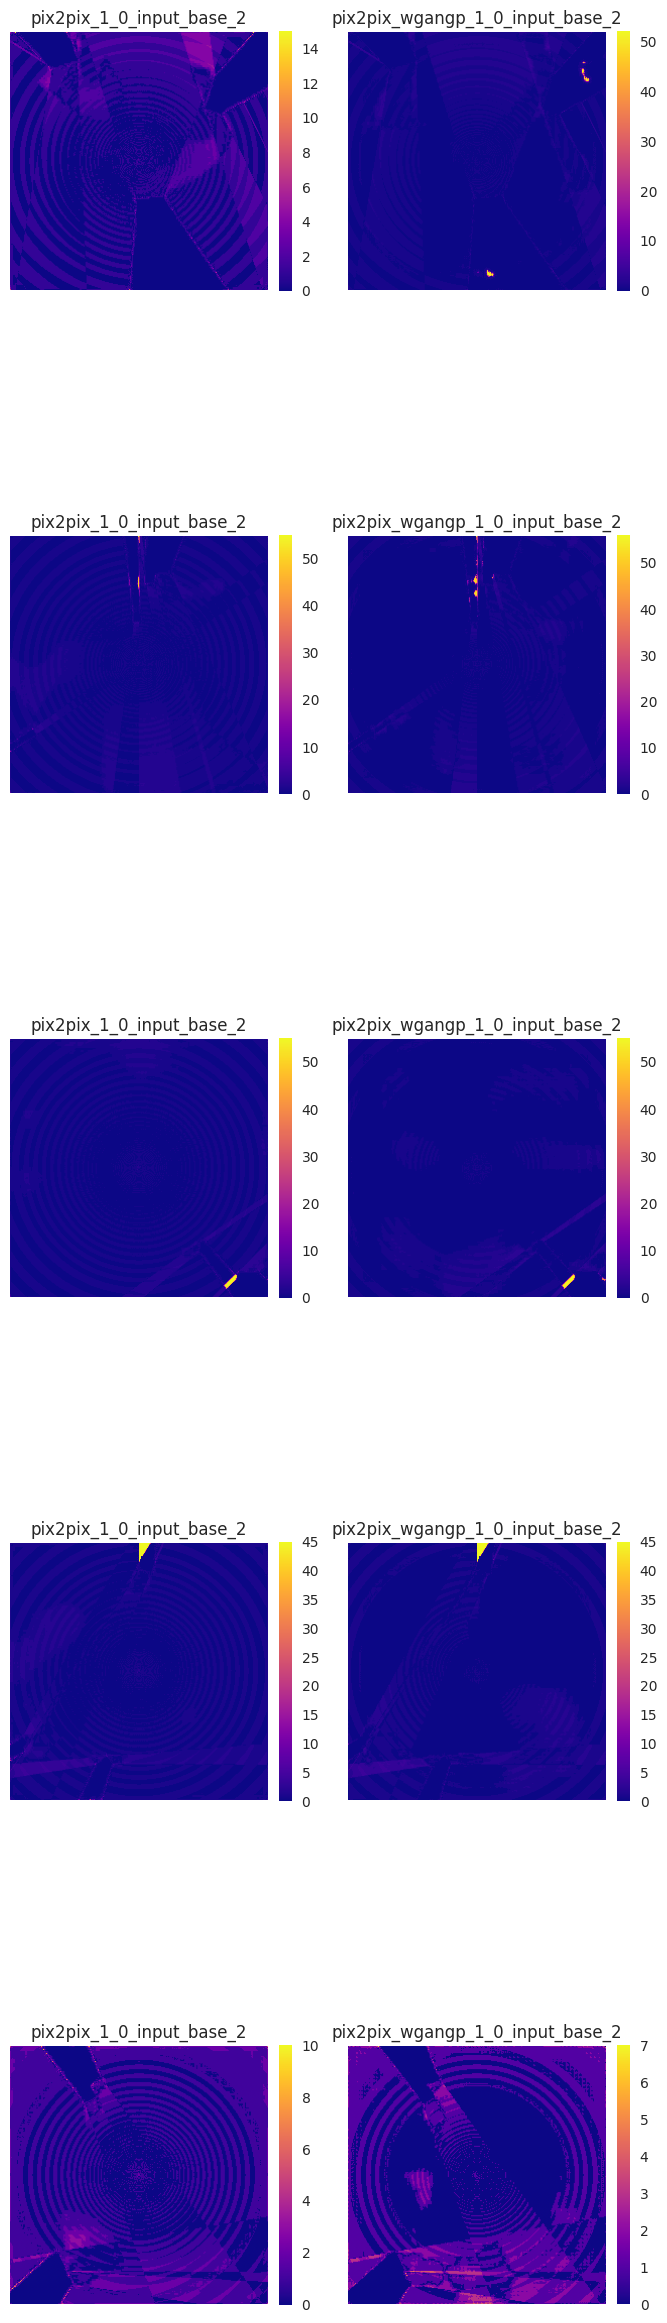

In [91]:
fig, ax = plt.subplots(nrows=n_samples, ncols=2, figsize=(2*4, n_samples*6))

for idx, cur_path in enumerate(pred_model_1):
    plot(ax[idx][0], path=cur_path, title=f"{model_1}", sub_image=real[idx], cmap="plasma")

for idx, cur_path in enumerate(pred_model_2):
    plot(ax[idx][1], path=cur_path, title=f"{model_2}", sub_image=real[idx], cmap="plasma")

plt.subplots_adjust(hspace=0.7)
plt.show();

Inspect some single images in more detail here:

In [85]:
from skimage.measure import block_reduce

def plot_image_with_values(img, block_size=8):
    # Compute mean over non-overlapping blocks
    mean_img = block_reduce(img, block_size=(block_size, block_size), func=np.mean)
    max_value = mean_img.max()

    # Plot the mean image
    plt.imshow(mean_img, cmap='gray', interpolation='nearest')
    plt.colorbar(label='Mean Value')

    # Annotate each block with the mean
    for i in range(mean_img.shape[0]):
        for j in range(mean_img.shape[1]):
            val = mean_img[i, j]
            color = 'white' if val < max_value/1.5 else 'black'
            # color = int(255 - val)
            plt.text(j, i, f'{val:.1f}', ha='center', va='center',
                     color=color, fontsize=6)

    plt.title(f'Mean Values over {block_size}x{block_size} Blocks')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

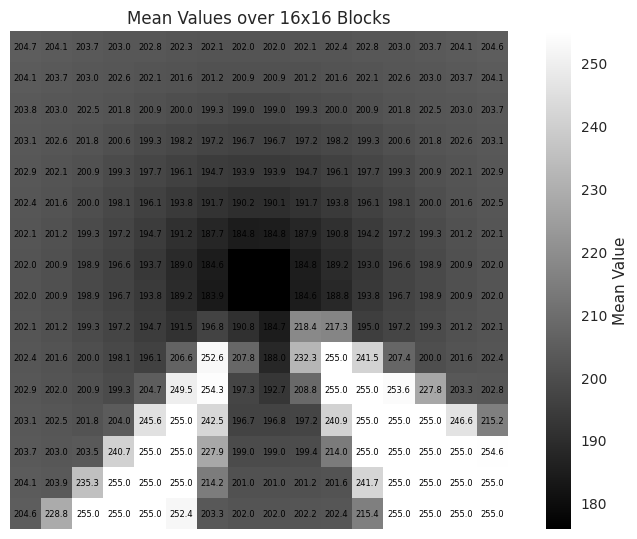

In [86]:
img_path = pred_model_1[0]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(float)

plot_image_with_values(img, block_size=16)

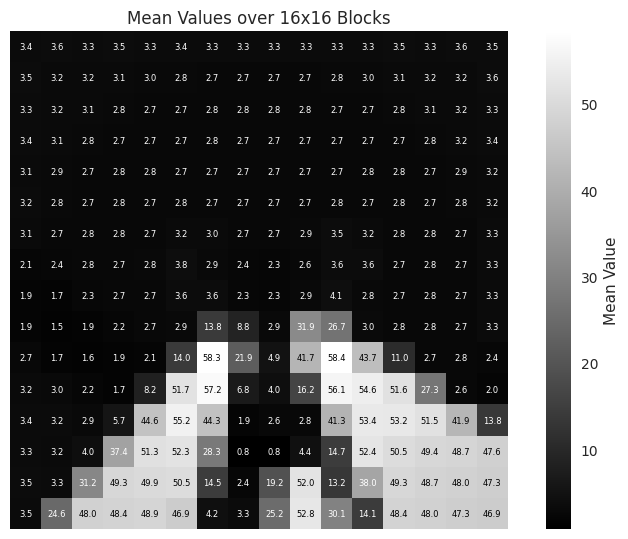

In [87]:
img = plot(None, path=pred_model_1[0], title=f"{model_1}", sub_image=real[idx], plot=False)
plot_image_with_values(img, block_size=16)